<a href="https://colab.research.google.com/github/RajeshworM/Zomato_Analysis/blob/main/zomato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import libraries and Load Data**
Data Cleaning:

We remove unnecessary columns and duplicates, handle missing values, and convert categorical features using encoding.
Correlation Analysis (Heatmap):

A correlation heatmap is generated to visualize relationships between variables. This helps in selecting the most important features that correlate with the target variable (rate).
Feature Selection:

Based on the correlation analysis, we select features that have an absolute correlation greater than 0.2 with the target variable (rate).
Splitting Data & Scaling:

We split the dataset into training and testing sets and apply standard scaling to the features.
Model Training & Evaluation:

We train and evaluate multiple machine learning models (Linear Regression, Decision Tree, Random Forest, and SVR) and calculate the Root Mean Squared Error (RMSE) and R-squared (R²) score for each model.
Feature Importance (Random Forest):

A bar plot of feature importance is generated for the Random Forest model to show which features contribute the most to predicting rate.
Actual vs Predicted Plots:

We plot the actual vs predicted ratings for each model to visualize how well each model fits the test data.
Residual Analysis:

A residual plot is generated to show the distribution of errors (residuals) for each model. This helps assess how well the models fit the data.
Conclusion:
This program not only performs data cleaning and machine learning modeling but also provides graphical representations that offer insights into model performance and feature importance.

In [11]:
!pip install pandas numpy seaborn matplotlib scikit-learn

                                                 url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5  

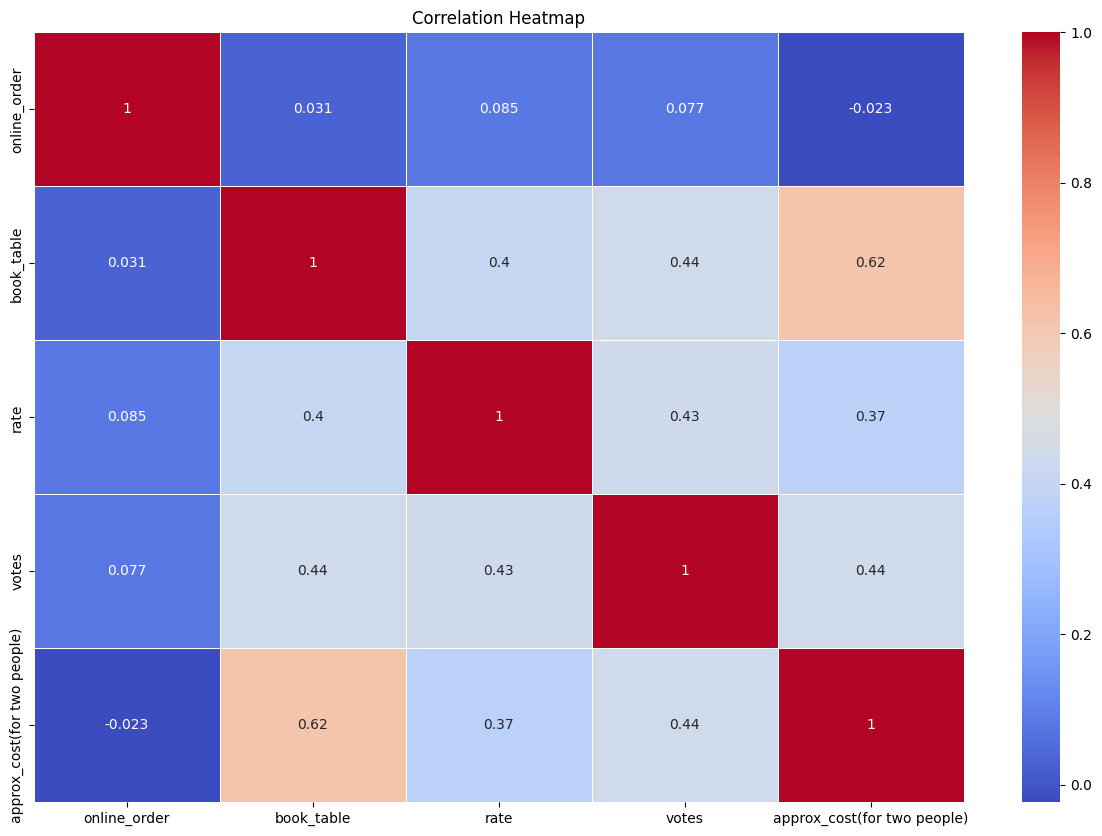

Selected Features based on correlation: Index(['votes', 'book_table', 'approx_cost(for two people)'], dtype='object')


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# Step 1: Load the Dataset
csv_file_path = '/content/drive/My Drive/zomato.csv'  # Adjust the path if necessary
df = pd.read_csv(csv_file_path)
print(df.head())

# Step 2: Data Cleaning

# Remove duplicates
df.drop_duplicates(inplace=True)

# Remove unnecessary columns
df = df.drop(['url', 'address', 'phone', 'reviews_list', 'menu_item'], axis=1)

# Handle missing values and clean the data
df['rate'] = df['rate'].replace('NEW', np.nan)
df['rate'] = df['rate'].replace('-', np.nan)
df['rate'] = df['rate'].str.replace('/5', '').astype(float)
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].str.replace(',', '').astype(float)

# Fill missing values with median
df['rate'].fillna(df['rate'].median(), inplace=True)
df['approx_cost(for two people)'].fillna(df['approx_cost(for two people)'].median(), inplace=True)

# Encoding categorical variables
df['online_order'] = df['online_order'].map({'Yes': 1, 'No': 0})
df['book_table'] = df['book_table'].map({'Yes': 1, 'No': 0})
df = pd.get_dummies(df, columns=['location', 'rest_type', 'listed_in(type)', 'listed_in(city)', 'cuisines'], drop_first=True)

# Step 3: Remove Outliers
q_low = df['rate'].quantile(0.01)
q_hi = df['rate'].quantile(0.99)
df = df[(df['rate'] > q_low) & (df['rate'] < q_hi)]

q_low_cost = df['approx_cost(for two people)'].quantile(0.01)
q_hi_cost = df['approx_cost(for two people)'].quantile(0.99)
df = df[(df['approx_cost(for two people)'] > q_low_cost) & (df['approx_cost(for two people)'] < q_hi_cost)]

# Step 4: Correlation Heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(15, 10))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Step 5: Select Important Features Based on Correlation
correlation_threshold = 0.2
correlated_features = correlation_matrix['rate'].abs().sort_values(ascending=False)
important_features = correlated_features[correlated_features > correlation_threshold].index
important_features = important_features.drop('rate')  # Remove 'rate' itself

print(f"Selected Features based on correlation: {important_features}")

# Step 6: Prepare Data for Machine Learning
X = df[important_features]
y = df['rate']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Add Polynomial Features for Linear Regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Step 8: Model Training and Hyperparameter Tuning

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

# Hyperparameter tuning for RandomForest and SVR
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Train and tune models
def evaluate_model(model, X_train, y_train, X_test, y_test, poly=False):
    if poly:
        model.fit(X_train_poly, y_train)
        y_pred = model.predict(X_test_poly)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return y_pred, rmse, r2

# Store evaluation results for all models
evaluation_results = {}

# Linear Regression with Polynomial Features
y_pred_lr, rmse_lr, r2_lr = evaluate_model(models['Linear Regression'], X_train, y_train, X_test, y_test, poly=True)
evaluation_results['Linear Regression (Polynomial)'] = {'RMSE': rmse_lr, 'R2': r2_lr}

# Lasso Regression
y_pred_lasso, rmse_lasso, r2_lasso = evaluate_model(models['Lasso Regression'], X_train_scaled, y_train, X_test_scaled, y_test)
evaluation_results['Lasso Regression'] = {'RMSE': rmse_lasso, 'R2': r2_lasso}

# Ridge Regression
y_pred_ridge, rmse_ridge, r2_ridge = evaluate_model(models['Ridge Regression'], X_train_scaled, y_train, X_test_scaled, y_test)
evaluation_results['Ridge Regression'] = {'RMSE': rmse_ridge, 'R2': r2_ridge}

# Decision Tree Regressor
y_pred_dt, rmse_dt, r2_dt = evaluate_model(models['Decision Tree Regressor'], X_train, y_train, X_test, y_test)
evaluation_results['Decision Tree Regressor'] = {'RMSE': rmse_dt, 'R2': r2_dt}

# Random Forest (with GridSearchCV)
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
evaluation_results['Random Forest Regressor'] = {'RMSE': rmse_rf, 'R2': r2_rf}

# Support Vector Regressor (with GridSearchCV)
grid_svr = GridSearchCV(SVR(), param_grid_svr, cv=3)
grid_svr.fit(X_train_scaled, y_train)
y_pred_svr = grid_svr.predict(X_test_scaled)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)
evaluation_results['Support Vector Regressor'] = {'RMSE': rmse_svr, 'R2': r2_svr}

# Step 9: Conclusion and Best Model

# Print the evaluation results for all models
for model_name, result in evaluation_results.items():
    print(f"{model_name}: RMSE = {result['RMSE']:.4f}, R2 = {result['R2']:.4f}")

# Identify the best model based on R² score
best_model = max(evaluation_results, key=lambda x: evaluation_results[x]['R2'])
print(f"\nBest Model: {best_model} with R² = {evaluation_results[best_model]['R2']:.4f}")

# Step 10: Visualizations (Actual vs Predicted and Residuals)

def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.grid(True)
    plt.show()

# Plot Actual vs Predicted for best model
plot_actual_vs_predicted(y_test, y_pred_rf, 'Random Forest Regressor')

# Residuals Plot
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, color='purple', edgecolor='k', alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', lw=2)  # Corrected line
    plt.title(f'Residuals Plot - {model_name}')
    plt.xlabel('Predicted Ratings')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

# Plot Residuals for best model
plot_residuals(y_test, y_pred_rf, 'Random Forest Regressor')
